# Debugging:
## This script imports C and Python HDF output for comparison

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import subprocess

# Labels and timestamps

In [2]:
#####################################################
#
# Time labels for C and Python
#

t_label = '066'
label = t_label + '_' + 'ic'

# label = t_label + '_' + 'before_advect'
# label = t_label + '_' + 'after_advect'
label = t_label + '_' + 'after_ebnaexp'
# label = t_label + '_' + 'after_ebnaimp'
# label = t_label + '_' + 'after_half_step'
# label = t_label + '_' + 'after_efna'
# label = t_label + '_' + 'after_full_advect'
# label = t_label + '_' + 'after_full_ebnaexp'
label = t_label + '_' + 'after_full_step'

# t_label = '038'
# time = t_label + '_' + 'after_full_step'
time = label

# t_label = '112'
# label = t_label + '_' + 'ic'

# label = t_label + '_' + 'before_advect'
# label = t_label + '_' + 'after_advect'
label = t_label + '_' + 'after_ebnaexp'
# label = t_label + '_' + 'after_ebnaimp'
# label = t_label + '_' + 'after_half_step'
# label = t_label + '_' + 'after_efna'
# label = t_label + '_' + 'after_full_advect'
# label = t_label + '_' + 'after_full_ebnaexp'
label = t_label + '_' + 'after_full_step'

# 
#####################################################

#####################################################
#
# C-output folder names
#
base_suffix = '._acoustic_wave_high/'
base_suffix = '_internal_long_wave/'
# base_suffix = '_travelling_vortex_3d_48_no_initial_projection/'
# base_suffix = '_travelling_vortex_3d_48_with_initial_projection/'
# base_suffix = '_rising_bubble/'
# 
#####################################################
#
# and its filename
#
# model_type = 'low_mach_gravity_comp'
# model_type = 'low_mach_gravity_psinc'
# model_type = 'low_mach_gravity_hydro'
model_type = 'low_mach_gravity_comp_long'
# py_filename = "output_acoustic_wave_high_" + model_type + ".h5"
py_filename = "output_internal_long_wave_" + model_type + ".h5"
# py_filename = "output_travelling_vortex_3d_48_" + model_type + ".h5"
# py_filename = "output_rising_bubble_" + model_type + ".h5"

#####################################################

figsize_tuple = (12,3)

## Converter

Converts all hdf4 output of RKLM C-code to hdf5.

In [4]:
base_folder_name = "../RKLM_Reference/output"

base_path = base_folder_name + base_suffix
folder_type = "low_Mach_gravity_comp/"
# folder_type = "low_Mach_gravity_psinc/"

# Manually list the folder names for each output
directories = ['S', 'T', 'Y', 'buoy', 'dT', 'dY', 'dp2_c', 'dp2_nodes', 'dpdim', 'drhoY', 'p', 'p2_c', 'p2_nodes', 'rho', 'rhoY', 'rhoe', 'u', 'v', 'vortz', 'w']
directories += ['rhou', 'rhov', 'rhow', 'rhs']
directories += ['buoy', 'drhoY']

# And manually list the file names.
filenames = ['S', 'T', 'Y', 'buoy', 'dT', 'dY', 'dp2_c', 'dp2_n', 'dpdim', 'drhoY', 'p', 'p2_c', 'p2_n', 'rho', 'rhoY', 'rhoe', 'u', 'v', 'vortz', 'w']
filenames += ['rhou', 'rhov', 'rhow', 'rhs']
filenames += ['buoy', 'drhoY']

# specify the format extensions for input and output of converter
hdf_format = '.'+ 'hdf'
h5_format = '.' + 'h5'

if time == '001' or time == '005':
    directories += ['flux_x', 'flux_y']
    filenames += ['rhoYu', 'rhoYv']

if time == t_label + '_' + 'after_ebnaimp':
    directories += ['wplusx', 'wplusy', 'hcenter', 'pnew', 'rhs_nodes', 'p2_initial']
    filenames += ['wplusx', 'wplusy', 'hcenter', 'p2_full', 'rhs_nodes', 'p2_initial']

string_hdf = '_' + time + hdf_format
string_h5 = '_' + time + h5_format
full_path = base_path + folder_type

lst_hdf = []
lst_h5 = []

# build list of paths from parameters specified above.
i = 0
for directory in directories:
    lst_hdf.append(full_path + directory + '/' + filenames[i] + string_hdf)
    lst_h5.append(full_path + directory + '/' + filenames[i] + string_h5)
    i += 1 

# print the list of paths
for path in lst_hdf:
    print(path)

# now, convert the arrays specified in the list of paths
for item in lst_hdf:
    p = subprocess.call(["./h4toh5convert", item])

../RKLM_Reference/output_internal_long_wave/low_Mach_gravity_comp/S/S_066_after_full_step.hdf
../RKLM_Reference/output_internal_long_wave/low_Mach_gravity_comp/T/T_066_after_full_step.hdf
../RKLM_Reference/output_internal_long_wave/low_Mach_gravity_comp/Y/Y_066_after_full_step.hdf
../RKLM_Reference/output_internal_long_wave/low_Mach_gravity_comp/buoy/buoy_066_after_full_step.hdf
../RKLM_Reference/output_internal_long_wave/low_Mach_gravity_comp/dT/dT_066_after_full_step.hdf
../RKLM_Reference/output_internal_long_wave/low_Mach_gravity_comp/dY/dY_066_after_full_step.hdf
../RKLM_Reference/output_internal_long_wave/low_Mach_gravity_comp/dp2_c/dp2_c_066_after_full_step.hdf
../RKLM_Reference/output_internal_long_wave/low_Mach_gravity_comp/dp2_nodes/dp2_n_066_after_full_step.hdf
../RKLM_Reference/output_internal_long_wave/low_Mach_gravity_comp/dpdim/dpdim_066_after_full_step.hdf
../RKLM_Reference/output_internal_long_wave/low_Mach_gravity_comp/drhoY/drhoY_066_after_full_step.hdf
../RKLM_Refere

FileNotFoundError: [Errno 2] No such file or directory: './h4toh5convert': './h4toh5convert'

## Import C hdf5 output

Import the test case arrays from the c-output.

In [166]:
# manually specific folder names
test_cases_folders = ['p2_c', 'dp2_nodes', 'p', 'p2_nodes', 'rho', 'rhoY', 'rhoe', 'rhou', 'rhov', 'rhow', 'u', 'vortz', 'dpdim', 'T', 'dT', 'Y', 'dY', 'dp2_c']
# test_cases_folders += ['debug', 'debug', 'debug']

test_cases_folders += ['rhs']
test_cases_folders += ['buoy', 'drhoY']

# and filenames
test_cases_names = ['p2_c', 'dp2_n', 'p', 'p2_n', 'rho', 'rhoY', 'rhoe', 'rhou', 'rhov', 'rhow', 'u', 'vortz', 'dpdim', 'T', 'dT', 'Y', 'dY', 'dp2_c']

test_cases_names += ['rhs']
test_cases_names += ['buoy', 'drhoY']

if time == '001' or time == '005':
    test_cases_folders += ['flux_x','flux_y']
    test_cases_names += ['rhoYu', 'rhoYv']

if time == t_label + '_' + 'after_ebnaimp':
    test_cases_folders += ['wplusx', 'wplusy', 'hcenter', 'pnew', 'rhs_nodes', 'p2_initial']
    test_cases_names += ['wplusx', 'wplusy', 'hcenter', 'p2_full', 'rhs_nodes', 'p2_initial']
    
test_cases_folders = np.char.array(test_cases_folders)
test_cases_names = np.char.array(test_cases_names)
    
# build paths from folder names and filenames
test_cases_paths = full_path + test_cases_folders + '/' + test_cases_names + string_h5

# define empty class as a holder for all the C-hdf5 output.
class c_output(object):
    def __init__(self):
        None
        
    def c_out(self):
        for key,value in vars(self).items():
            setattr(self,key,value['Data-Set-2'])
            
# get an instance of an empty class to populate it with the C-HDF output as attributes
c = c_output()

# populate the class with the C-HDF output as attributes
i = 0
for path in test_cases_paths:
    setattr(c,test_cases_folders[i],h5py.File(path, 'r'))
    i += 1
    
    
# run the method to extract array from HDF objects
c.c_out()

## Import the Python output

In [170]:
# specify directory where the python hdf5 output is.
# py_directory = "../RKLM_Python/"
py_directory = "../"
py_folder = "output_internal_long_wave/"

py_path = py_directory + py_folder + py_filename

# helper function to extract array from hdf file by its name and timestep

label = '_' + label
def py_out(py_dataset,time=label):
    return pyfile[str(py_dataset)][str(py_dataset)+time][:]

## Helper diagnostic functions

In [171]:
# print an array
def p(obj):
    print(obj)
    
# visualise an array
def v(obj):
    plt.imshow(obj)
    plt.colorbar()
    plt.show()
    
# plot a slice of the array, default is x = 0 for all y (slice at origin)
def s(obj,slc=(slice(None))):
    plt.plot(obj['Data-Set-2'][slc])
    plt.show()
    
# plot the difference between the C and Python outputs
def diff(obj_c, obj_py, title, option = None):
#     obj_c = obj_c[2:-2,2:-2]
#     obj_c -= obj_c.mean()
#     obj_py = obj_py[2:-2,2:-2]
#     obj_py -= obj_py.mean()
#     
    c_range = np.max(obj_c) - np.min(obj_c)
    py_range = np.max(obj_py) - np.min(obj_py)
    if option == None:
        max_norm = np.abs(obj_c - obj_py)
    else:
        max_norm = (obj_c - obj_py)
    
    max_diff = np.max(max_norm)
    
    fig, ax = plt.subplots(ncols=3, figsize=figsize_tuple)
    # plot c array
    im_c = ax[0].pcolor(obj_c, label="c")
    fig.colorbar(im_c,ax=ax[0])
    ax[0].set_title("c")
    ax[0].set_aspect('auto')
    
    # plot python array
    im_py = ax[1].pcolor(obj_py, label="py")
    fig.colorbar(im_py,ax=ax[1])
    ax[1].set_title("py")
    ax[1].set_aspect('auto')

    # plot the difference between the two
    im_diff = ax[2].pcolor(max_norm, label="diff")
    fig.colorbar(im_diff,ax=ax[2])
    ax[2].set_title("diff")
    ax[2].set_aspect('auto')
    
    # calculate the max difference relative to the C-output for non-zero values.
    if c_range == 0.0:
        rel_diff = 0.0
    else:
        rel_diff = max_diff/c_range
        
    print("comparison = %s,\nc_range = %e, py_range = %e, \nmax diff = %e, rel. diff = %e," %(title, c_range, py_range, max_diff, rel_diff))
    plt.tight_layout(h_pad=1)
    plt.show()
    print("################################################## \n")

comparison = p2_nodes,
c_range = 2.223749e-05, py_range = 2.223562e-05, 
max diff = 2.210982e-09, rel. diff = 9.942587e-05,


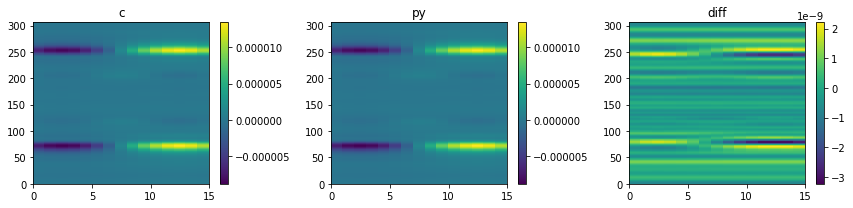

################################################## 

comparison = buoy,
c_range = 1.401037e-05, py_range = 1.400905e-05, 
max diff = 2.866727e-09, rel. diff = 2.046146e-04,


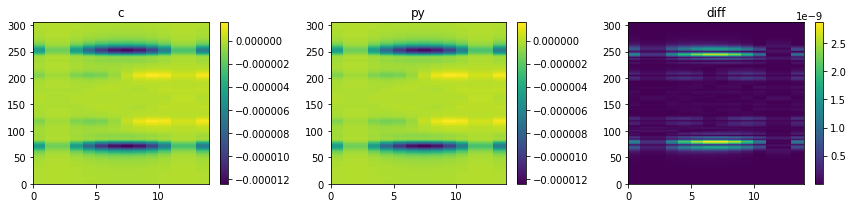

################################################## 

comparison = rho,
c_range = 8.450689e-01, py_range = 8.450689e-01, 
max diff = 1.192093e-07, rel. diff = 1.410646e-07,


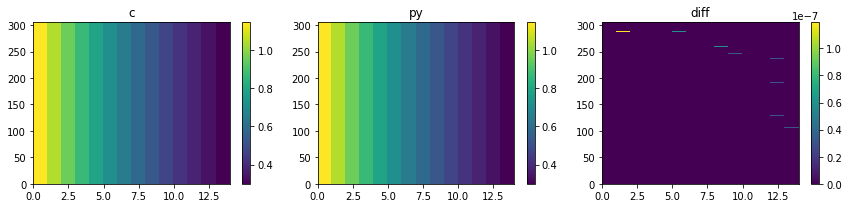

################################################## 

comparison = rhoY,
c_range = 7.904176e-01, py_range = 7.904176e-01, 
max diff = 1.192093e-07, rel. diff = 1.508181e-07,


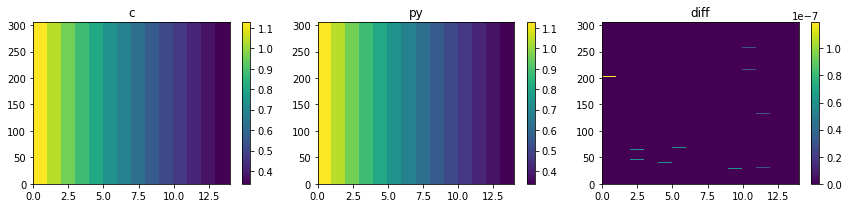

################################################## 

comparison = rhou,
c_range = 1.691506e-01, py_range = 1.691506e-01, 
max diff = 1.490116e-08, rel. diff = 8.809404e-08,


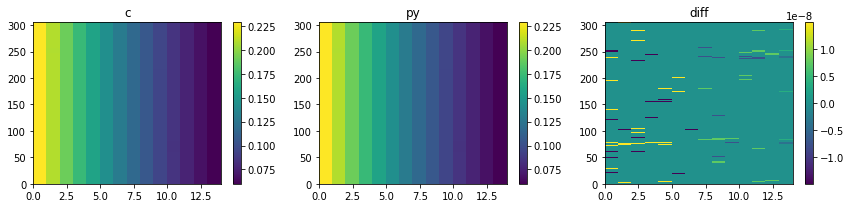

################################################## 

comparison = rhov,
c_range = 2.492922e-06, py_range = 2.493000e-06, 
max diff = 1.078888e-10, rel. diff = 4.327805e-05,


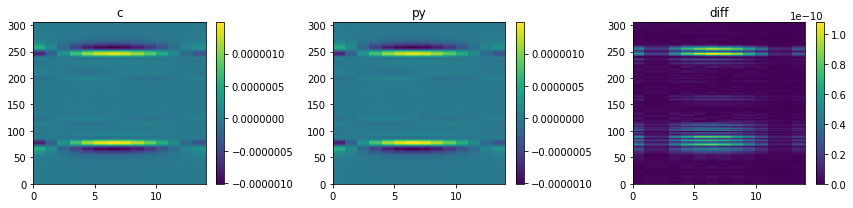

################################################## 

comparison = rhow,
c_range = 0.000000e+00, py_range = 0.000000e+00, 
max diff = 0.000000e+00, rel. diff = 0.000000e+00,


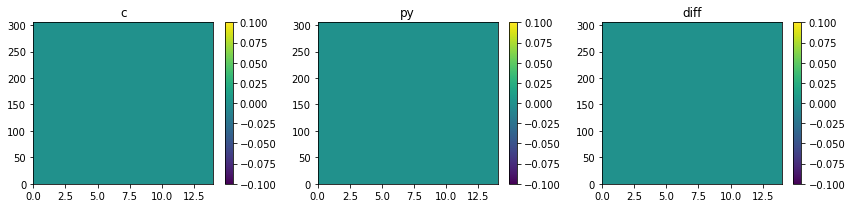

################################################## 

comparison = vortz,
c_range = 8.235001e-04, py_range = 8.234946e-04, 
max diff = 1.330045e-08, rel. diff = 1.615112e-05,


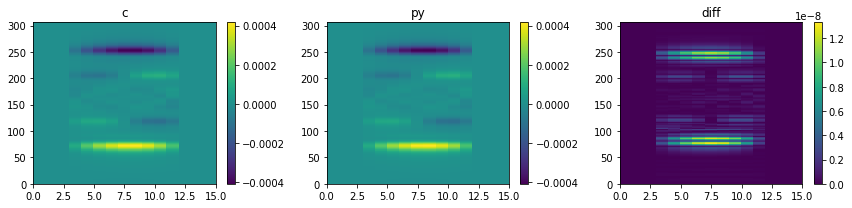

################################################## 

comparison = Y,
c_range = 1.395492e-01, py_range = 1.395492e-01, 
max diff = 1.192093e-07, rel. diff = 8.542456e-07,


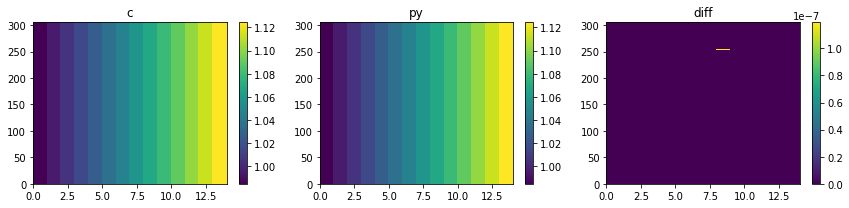

################################################## 

comparison = drhoY,
c_range = 4.972229e-05, py_range = 4.972184e-05, 
max diff = 9.983978e-10, rel. diff = 2.007948e-05,


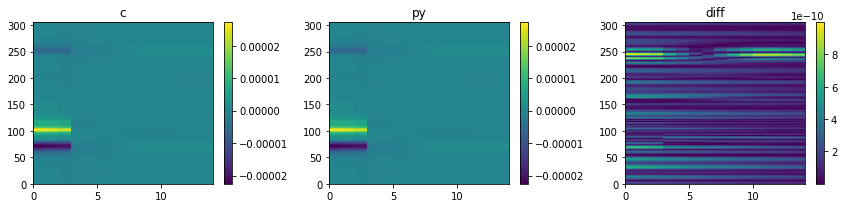

################################################## 

comparison = dY,
c_range = 1.571248e-05, py_range = 1.571268e-05, 
max diff = 9.204086e-10, rel. diff = 5.857819e-05,


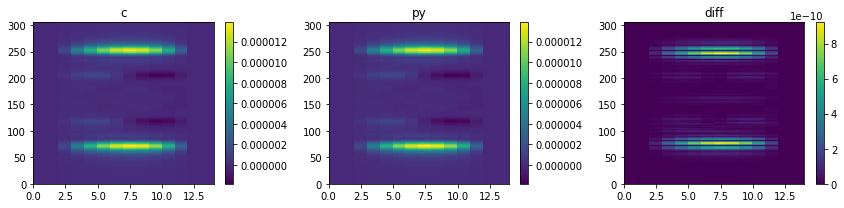

################################################## 



In [172]:
# open the Python HDF file
pyfile = h5py.File(py_path, 'r')

# make comparisons for the arrays.
# Arguments: C-array (class attribute), Python-array (numpy array), and a title.
# PPP = np.copy(py_out('dp2_nodes'))
# PPP[:,-4:-2] = py_out('dp2_nodes')[:,2:4][::-1]

# diff(c.pnew, PPP, 'dp2_nodes')

inner = (slice(2,-2),slice(2,-2))
iwp = (slice(2,-2),slice(2,-2))
iwp_e = (slice(2,-2),slice(2,-2))
iwp_n = (slice(2,-3),slice(2,-3))
# iwp = (slice(None),slice(None))
if time == t_label + '_' + 'after_ebnaimp':
#     diff(c.hcenter, py_out('hcenter'), 'hcenter')
#     diff(c.wplusx[iwp], py_out('wplusx')[iwp_n], 'wplusx')
#     diff(c.wplusy[iwp], py_out('wplusy')[iwp_n], 'wplusy')
    diff(c.pnew[inner], py_out('p2_full')[inner], 'p2_full', option='na')
#     diff(c.rhs_nodes, py_out('rhs_nodes'), 'rhs_nodes')
#     diff(c.p2_initial, py_out('p2_initial'), 'p2_initial')
    
if time == '001' or time == '005':
    diff(c.flux_x, py_out('rhoYu').T, 'rhoYu')
    diff(c.flux_y, py_out('rhoYv').T, 'rhoYv')
    
# print(py_out('lap_test'))
# fig = plt.figure(figsize=(5,5))
# plt.pcolor(py_out('lap_test'))
# plt.colorbar()
# plt.show()

# diff(c.pnew,py_out('dp2_nodes'),'dp2_nodes')
# diff(c.rhs, py_out('rhs'), 'rhs')
diff(c.p2_nodes,py_out('p2_nodes'),'p2_nodes', option='na')
diff(c.buoy,py_out('X'),'buoy')
# diff(c.dp2_c,py_out('dp2_cells'),'dp2_cells')
# diff(c.p2_c,py_out('p2_cells'),'p2_cells')

diff(c.rho,py_out('rho'),'rho')
# # diff(c.rhoe,py_out('rhoe'),'rhoe')
diff(c.rhoY,py_out('rhoY'),'rhoY')

diff(c.rhou,py_out('rhou'),'rhou', option='na')
# # print(np.argmax(np.abs(c.rhou - py_out('rhou'))))
diff(c.rhov,py_out('rhov'),'rhov')
diff(c.rhow,py_out('rhow'),'rhow')

# diff(c.u, py_out('u'), 'u')
# diff(c.p, py_out('p'), 'p')
# diff(c.dpdim, py_out('dpdim'), 'dpdim')
diff(c.vortz, py_out('vortz'), 'vortz')

# diff(c.T, py_out('T'), 'T')
# diff(c.dT, py_out('dT'), 'dT')

diff(c.Y, py_out('Y'), 'Y')
diff(c.drhoY, py_out('drhoY'), 'drhoY')
diff(c.dY, py_out('dY'), 'dY')

# print(c.hcenter[:][2:-2,2:-2])
# print(py_out('hcenter')[2:-2,2:-2])

# print(np.where(py_out('p2_initial')[inner] == 0.)[0])

# if time == '004':
#     idx = 0
#     fig = plt.figure(figsize=(9,9))
#     plt.plot(py_out('p2_full')[inner][:,idx], 'r')
#     plt.plot(c.pnew[inner][:,7])
#     plt.xlabel('p2_full')
#     plt.ylabel('error')
#     plt.show()

#     fig = plt.figure(figsize=(9,9))
#     plt.plot((py_out('p2_full') - c.pnew)[inner][:,idx])
#     plt.xlabel('diff')
#     plt.ylabel('error')
#     plt.show()
    
#     fig = plt.figure(figsize=(9,9))
#     plt.plot((py_out('p2_initial')[inner])[:,7])
#     plt.xlabel('p2_initial')
#     plt.ylabel('value')
#     plt.show()
    
#     print(py_out('p2_initial')[inner][2,:][:10])
    
if time == '002':
    idx = 1
    fig = plt.figure(figsize=(9,9))
    plt.plot(py_out('rhou')[:,idx],'r', label='python-output')
    plt.plot(c.rhou[:,idx],'k', label='c-output')
    plt.title('rhou, sliced at idx %i' %idx )
    plt.ylabel('rhou')
    plt.xlabel('x')
    plt.legend()
    plt.show()
    
    fig = plt.figure(figsize=(9,9))
    plt.plot((py_out('rhou') - c.rhou)[:,idx])
    plt.title('difference in rhou outputs, sliced at idx %i' %idx )
    plt.xlabel('diff')
    plt.ylabel('error')
    plt.show()
    
    
if time == '007':
    idx = 10
    fig = plt.figure(figsize=(9,9))
#     plt.plot((py_out('p2_nodes') - c.p2_nodes)[:,idx])
#     plt.plot(py_out('rhou')[:,idx][:2],'r', label='python-output')
#     plt.plot(c.rhou[:,idx][:2],'k', label='c-output')
    plt.plot((py_out('rhou') - c.rhou)[:,idx][:5])
    plt.title('difference in rhou outputs, sliced at idx %i' %idx )
    plt.xlabel('diff')
    plt.ylabel('error')
    plt.show()
    
if time == '005':
    idx = 3
    fig = plt.figure(figsize=(9,9))
    plt.plot((py_out('rhoYu').T - c.flux_x)[:,idx])
    plt.title('difference in rhoYu outputs, sliced at idx %i' %idx )
    plt.xlabel('diff')
    plt.ylabel('error')
    plt.show()
    
if time == '003':
    idx = 100
    fig = plt.figure(figsize=(9,9))
    plt.plot(py_out('rhov')[idx,:], '-ro',label='python')
    plt.plot(c.rhov[idx,:], '-bo',label='c')
    plt.title("rhov sliced at the 100th row (i.e. at x = 100)")
    plt.xlabel("y")
    plt.ylabel("rhov")
    plt.legend()
    plt.show()
    
# if time == t_label + '_' + 'after_half_step':
# idx = 7
# fig = plt.figure(figsize=(15,9))
# # plt.plot(py_out('rhou')[:,idx],'r', label='python-output')
# # plt.plot(c.rhou[:,idx],'k', label='c-output')
# plt.plot((py_out('rhou') - c.rhou)[:,idx], label='diff profile')
# plt.title('difference in rhou outputs, sliced at idx %i' %idx )
# plt.xlabel('diff')
# plt.ylabel('error')
# plt.legend()
# plt.show()

# idx = 12
# fig = plt.figure(figsize=(15,9))
# # plt.plot(py_out('p2_nodes')[:,idx],'r', label='python-output')
# # plt.plot(c.p2_nodes[:,idx],'k', label='c-output')
# plt.plot((py_out('p2_nodes') - c.p2_nodes)[:,idx], label='diff profile')
# plt.title('difference in p2_nodes outputs, sliced at idx %i' %idx )
# plt.xlabel('diff')
# plt.ylabel('error')
# plt.legend()
# plt.show()

# idx = 100
# fig = plt.figure(figsize=(15,9))
# plt.plot(py_out('p2_full')[inner][idx,:],'r', label='python-output')
# plt.plot(c.pnew[inner][idx,:],'k', label='c-output')
# # plt.plot((py_out('p2_nodes') - c.p2_nodes)[:,idx], label='diff profile')
# plt.title('difference in p2_nodes outputs, sliced at idx %i' %idx )
# plt.xlabel('diff')
# plt.ylabel('error')
# plt.legend()
# plt.show()

pyfile.close()

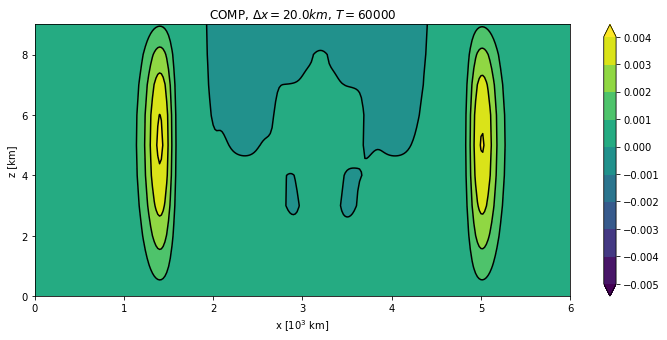

In [182]:
wave_type = '_long'
if wave_type == '_long':
    dx = '20.0'
    T = '60000'
    ticks = [0,1,2,3,4,5,6] # long wave
#     lvls = np.arange(-0.0025,0.00251,0.0005)
    lvls = np.arange(-0.005,0.005,0.001)
    
    
fig = plt.figure(figsize=(12,5))
plt.contour(c.dY[2:-2,2:-2].T * 300.,levels=lvls,colors='k')
plt.contourf(c.dY[2:-2,2:-2].T * 300.,levels=lvls,extend='both')
plt.colorbar()
plt.title("COMP, $\Delta x = %s km$, $T = %s$" %(dx,T))

plt.xticks(np.arange(0,301,50),ticks)
plt.yticks(np.arange(0,10,2),[0,2,4,6,8,10])
plt.xlabel('x [$10^3$ km]')
plt.ylabel('z [km]')

plt.show()

In [139]:
# pyfile = h5py.File(py_path, 'r')

# figsize_tuple = (25,4)
# fig, ax = plt.subplots(ncols=3, figsize=figsize_tuple)
# # plot c array

# inner = (slice(2,-2),slice(2,-2))
# lvls = np.linspace(-0.005, 0.005, 10)
# print(lvls)

# im_c = ax[0].contour(c.buoy[inner].T * 300)
# fig.colorbar(im_c,ax=ax[0])
# ax[0].set_title("c")
# ax[0].set_aspect('auto')

# # plot python array
# im_py = ax[1].contour(py_out('X')[inner].T * 300)
# fig.colorbar(im_py,ax=ax[1])
# ax[1].set_title("py")
# ax[1].set_aspect('auto')

# # plot the difference between the two
# im_diff = ax[2].pcolor(np.abs(c.buoy[inner].T * 300 - py_out('X')[inner].T * 300))
# fig.colorbar(im_diff,ax=ax[2])
# ax[2].set_title("diff")
# ax[2].set_aspect('auto')

# # plt.setp(ax, xlim=[0,160], ylim=[0,80], xticks=[0,40,80,120,160], xticklabels=np.arange(-10,10+1,5), yticks=[0,16,32,48,64,80], yticklabels=np.arange(0,11,2))

# pyfile.close()

In [161]:
# # plt.contour(c.rhoY[:].T / c.rho[:].T)
# # plt.contour(c.rho[:].T)

# # idx = 22
# lvls = np.arange(300.25,302.01,0.25)
# pyfile = h5py.File(py_path, 'r')
# # fig = plt.figure(figsize=(16,8))
# # # plt.pcolor(c.rhoY[:].T / c.rho[:].T * 300)
# # plt.contour(py_out('rhoY').T / py_out('rho').T * 300, levels=lvls)
# # plt.contour(c.rhoY[:].T / c.rho[:].T * 300, levels=lvls)
# # # plt.contour((c.rhoY[:].T / c.rho[:].T  - py_out('rhoY').T / py_out('rho').T) * 300  )
# # # plt.plot(py_out('rho').T[idx],label='py')
# # # plt.plot(c.rho[:].T[idx],label='c')
# # # plt.plot(c.rho[:].T[idx] - py_out('rho').T[idx])
# # # plt.legend()
# # # plt.vlines(82, 0, 80)
# # # plt.hlines(64,0,160)
# # # plt.contour(py_out('X').T)
# # plt.colorbar()
# # plt.ylim([0,80])
# # plt.xlim([0,160])
# # plt.yticks([0,16,32,48,64,80],np.arange(0,11,2))
# # plt.xticks([0,40,80,120,160],np.arange(-10,10+1,5))
# # plt.show()
# # print(pyfile['rhoY'].keys())

# figsize_tuple = (25,4)
# fig, ax = plt.subplots(ncols=3, figsize=figsize_tuple)
# # plot c array
# im_c = ax[0].pcolor(c.rhoY[:].T / c.rho[:].T * 300)
# fig.colorbar(im_c,ax=ax[0])
# ax[0].set_title("c")
# ax[0].set_aspect('auto')

# # plot python array
# im_py = ax[1].contour(py_out('rhoY').T / py_out('rho').T * 300, levels=lvls)
# fig.colorbar(im_py,ax=ax[1])
# ax[1].set_title("py")
# ax[1].set_aspect('auto')

# # plot the difference between the two
# im_diff = ax[2].pcolor(np.abs(c.rhoY[:].T / c.rho[:].T * 300 - py_out('rhoY').T / py_out('rho').T * 300))
# fig.colorbar(im_diff,ax=ax[2])
# ax[2].set_title("diff")
# ax[2].set_aspect('auto')

# # plt.setp(ax, xlim=[0,160], ylim=[0,80], xticks=[0,40,80,120,160], xticklabels=np.arange(-10,10+1,5), yticks=[0,16,32,48,64,80], yticklabels=np.arange(0,11,2))

# pyfile.close()

In [141]:
pyfile.close()

In [142]:
print((False and False))

False


In [10]:
py_filename = "output_internal_long_wave_low_mach_gravity_psinc.h5"
py_filename = "output_internal_long_wave_low_mach_gravity_hydro.h5"

py_directory = "../"

pref = 8.61 * 1e4
tref = 300.0
inner = (slice(2,-2),slice(2,-2))

def py_out(pyfile,py_dataset,time=label):
    return pyfile[str(py_dataset)][str(py_dataset)+time][:]

def get_path(filename):
    return py_directory + filename


def test_case(time):
    path = py_path
    file = h5py.File(path,'r')
    
    for t in time:
        if t < 10:
            t_label = '_00' + str(t) + '_' + 'after_full_step'
        elif t < 100:
            t_label = '_0' + str(t) + '_' + 'after_full_step'
        else:
            t_label = '_' + str(t) + '_' + 'after_full_step'


#     correction = (py_out(file,'drhoY',time=t_label) / py_out(file,'rho',time=t_label)) * 300
    correction = py_out(file,'dY',time=t_label) * tref
    
#     temp_perturb = background_temp - correction
    temp_perturb = correction
#     temp_perturb = background_temp

    file.close()
    return temp_perturb[inner].T

lvls = np.linspace(-0.005,0.005,11) # planetary wave
lvls = np.arange(-0.0025,0.00251,0.0005) # long , standard wave

print(lvls)

################# COMP ################

time = 112
T = '3000'
dx = '1'
ticks = [0,8,16,24,32,40,48] # planetary wave
ticks = [0,1,2,3,4,5,6] # long wave
ticks = [0,0.05,0.10,0.15,0.20,0.25,0.30] # standard

py_filename = "output_internal_long_wave_PIs1=0_PIs2=0_HYs1=0_HYs1=0_contblend.h5"
py_path = get_path(py_filename)

comp = test_case([time])

fig = plt.figure(figsize=(12,5))
plt.contour(comp,levels=lvls,colors='k')
plt.contourf(comp,levels=lvls,extend='both')
plt.colorbar()
plt.title("COMP, $\Delta x = %s km$, $T = %s$" %(dx,T))

plt.xticks(np.arange(0,301,50),ticks)
plt.yticks(np.arange(0,10,2),[0,2,4,6,8,10])
plt.xlabel('x [$10^3$ km]')
plt.ylabel('z [km]')

plt.show()

################# PI ################

py_filename = "output_internal_long_wave_low_mach_gravity_psinc.h5"
py_path = get_path(py_filename)

psinc = test_case([time])

fig = plt.figure(figsize=(12,5))
plt.contour(psinc,levels=lvls,colors='k')
plt.contourf(psinc,levels=lvls,extend='both')
plt.colorbar()
plt.title("PI, $\Delta x = %s km$, $T = %s$" %(dx,T))

plt.xticks(np.arange(0,301,50),ticks)
plt.yticks(np.arange(0,10,2),[0,2,4,6,8,10])
plt.xlabel('x [$10^3$ km]')
plt.ylabel('z [km]')

plt.show()

################# HY ################

# lvls = np.arange(-0.005,0.005,0.001)

py_filename = "output_internal_long_wave_PIs1=0_PIs2=0_HYs1=1_HYs1=5_contblend.h5"
py_path = get_path(py_filename)

hydro = test_case([time])

fig = plt.figure(figsize=(12,5))
plt.contour(hydro,levels=lvls,colors='k')
plt.contourf(hydro,levels=lvls,extend='both')
plt.colorbar()
plt.title("HY, $\Delta x = %s km$, $T = %s$" %(dx,T))

plt.xticks(np.arange(0,301,50),ticks)
plt.yticks(np.arange(0,10,2),[0,2,4,6,8,10])
plt.xlabel('x [$10^3$ km]')
plt.ylabel('z [km]')

plt.show()


lvls = np.arange(-4e-4,(6+1)*1e-4,1e-4) # planetary scale
lvls = np.arange(-4.0e-4,4.0e-4 + 5e-5,5e-5) # long wave
lvls = np.arange(-3e-4,3e-4 + 5e-5,5e-5) # standard

fig = plt.figure(figsize=(12,5))
plt.contour(comp - psinc,levels=lvls,colors='k')
plt.contourf(comp - psinc,levels=lvls, extend='both')
plt.colorbar()
plt.title("COMP - PI, $\Delta x = %s km$, $T = %s$" %(dx,T))

plt.xticks(np.arange(0,301,50),ticks)
plt.yticks(np.arange(0,10,2),[0,2,4,6,8,10])
plt.xlabel('x [$10^3$ km]')
plt.ylabel('z [km]')

plt.show()

lvls = np.arange(-1.5*1e-5, 1.*1e-5 + 3e-6, 3e-6) # planetary scale
lvls = np.arange(-5.*1e-5, 5.*1e-5 + 1e-5, 1e-5) # long wave
# lvls = np.arange(-4.*1e-3, 4.*1e-3 + 1e-3, 1e-3) # standard

fig = plt.figure(figsize=(12,5))
plt.contour(comp - hydro,levels=lvls,colors='k')
plt.contourf(comp - hydro,levels=lvls, extend='both')
plt.colorbar()
plt.title("COMP - HY, $\Delta x = %s km$, $T = %s$" %(dx,T))

plt.xticks(np.arange(0,301,50),ticks)
plt.yticks(np.arange(0,10,2),[0,2,4,6,8,10])
plt.xlabel('x [$10^3$ km]')
plt.ylabel('z [km]')

plt.show()

[-0.0025 -0.002  -0.0015 -0.001  -0.0005  0.      0.0005  0.001   0.0015
  0.002   0.0025]


OSError: Unable to open file (unable to open file: name = '../output_internal_long_wave_PIs1=0_PIs2=0_HYs1=0_HYs1=0_contblend.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

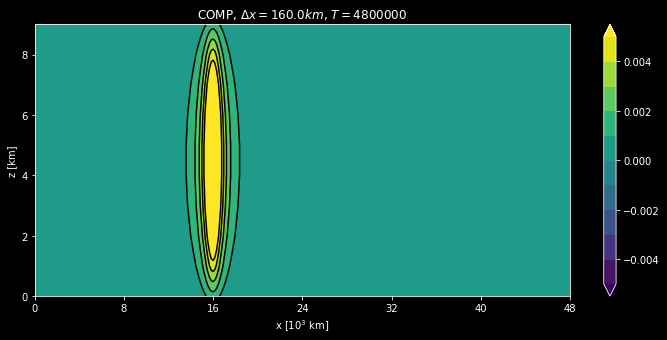

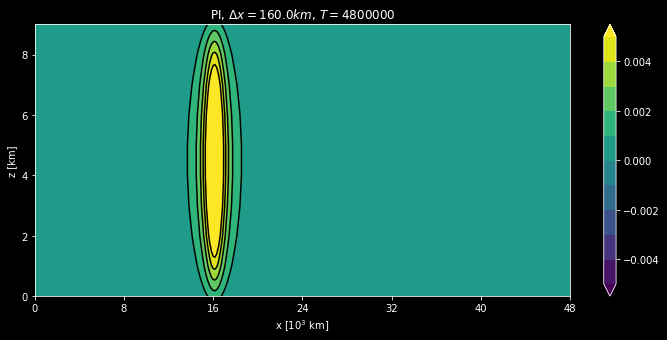

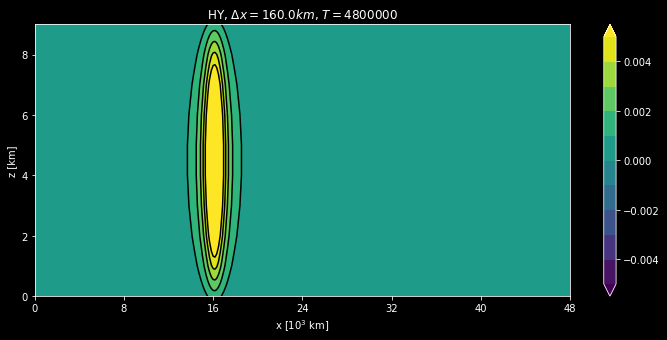

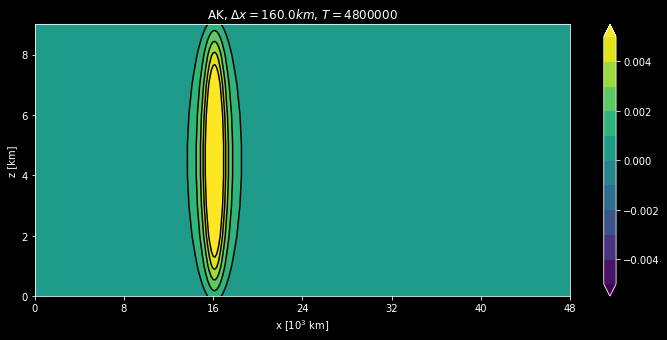

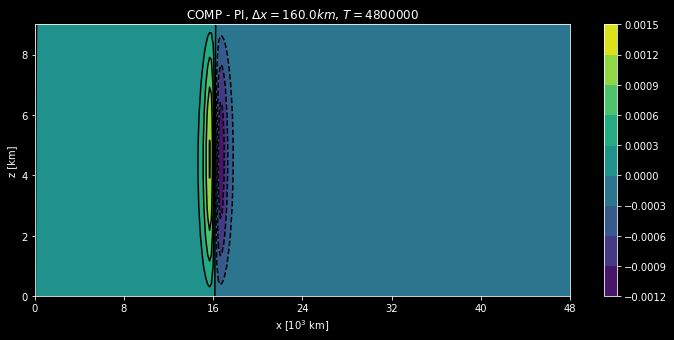

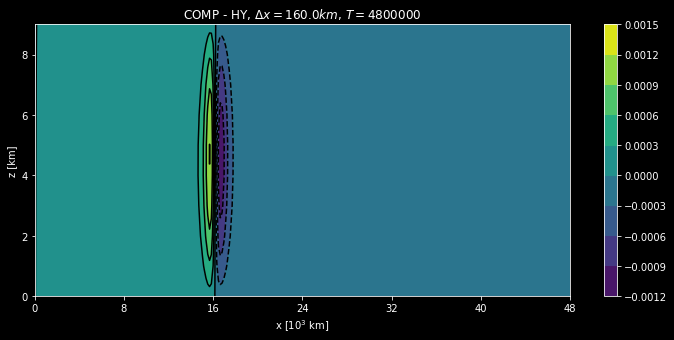

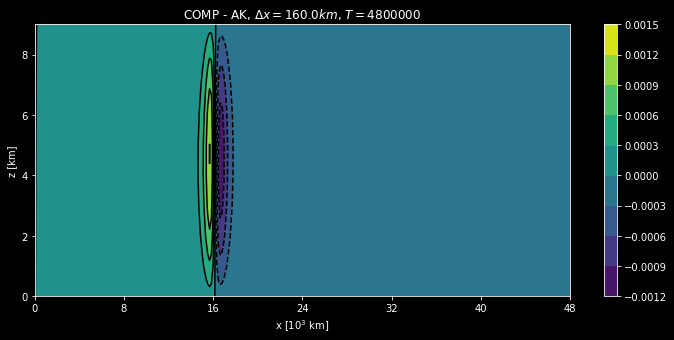

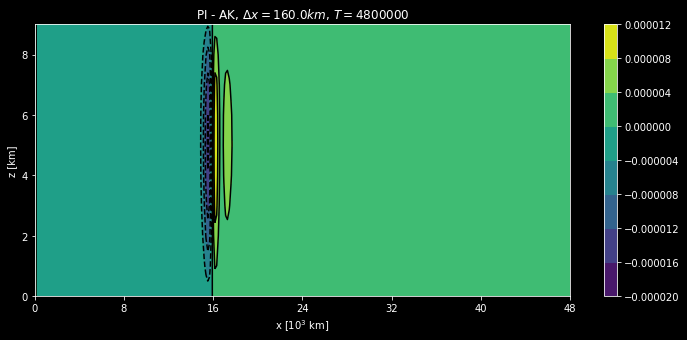

In [18]:
py_directory = "./"
py_directory += "output_internal_long_wave/"

pref = 8.61 * 1e4
tref = 300.0
inner = (slice(2,-2),slice(2,-2))

def py_out(pyfile,py_dataset,time):
    return pyfile[str(py_dataset)][str(py_dataset)+time][:]

def get_path(filename):
    return py_directory + filename


def test_case(time):
    path = py_path
    file = h5py.File(path,'r')
    
    for t in time:
        if t < 10:
            t_label = '_00' + str(t) + '_' + 'after_full_step'
        elif t < 100:
            t_label = '_0' + str(t) + '_' + 'after_full_step'
        else:
            t_label = '_' + str(t) + '_' + 'after_full_step'


#     correction = (py_out(file,'drhoY',time=t_label) / py_out(file,'rho',time=t_label)) * 300
    correction = py_out(file,'dY',time=t_label) * tref
    
#     temp_perturb = background_temp - correction
    temp_perturb = correction
#     temp_perturb = background_temp

    file.close()
    return temp_perturb[inner].T


time = 66
wave_type = '_standard'
wave_type = '_long'
wave_type = '_planetary'

if wave_type == '_standard':
    dx = '1.0'
    T = '3000'
    ticks = [0,0.05,0.10,0.15,0.20,0.25,0.30] # standard
    lvls = np.arange(-0.0025,0.00251,0.0005)
    
if wave_type == '_long':
    dx = '20.0'
    T = '60000'
    ticks = [0,1,2,3,4,5,6] # long wave
#     lvls = np.arange(-0.0025,0.00251,0.0005)
    lvls = np.arange(-0.005,0.005,0.001)
if wave_type == '_planetary':
    dx = '160.0'
    T = '4800000'
    ticks = [0,8,16,24,32,40,48] # planetary wave
    lvls = np.linspace(-0.005,0.005,11) # planetary wave

    

################# COMP ################

py_filename = "output_internal_long_wave_low_mach_gravity_comp" + wave_type + ".h5"
py_path = get_path(py_filename)

comp = test_case([time])

fig = plt.figure(figsize=(12,5))
plt.contour(comp,levels=lvls,colors='k')
plt.contourf(comp,levels=lvls,extend='both')
plt.colorbar()
plt.title("COMP, $\Delta x = %s km$, $T = %s$" %(dx,T))

plt.xticks(np.arange(0,301,50),ticks)
plt.yticks(np.arange(0,10,2),[0,2,4,6,8,10])
plt.xlabel('x [$10^3$ km]')
plt.ylabel('z [km]')

plt.show()

################# PI ################

py_filename = "output_internal_long_wave_low_mach_gravity_psinc" + wave_type + ".h5"
py_path = get_path(py_filename)

psinc = test_case([time])

fig = plt.figure(figsize=(12,5))
plt.contour(psinc,levels=lvls,colors='k')
plt.contourf(psinc,levels=lvls,extend='both')
plt.colorbar()
plt.title("PI, $\Delta x = %s km$, $T = %s$" %(dx,T))

plt.xticks(np.arange(0,301,50),ticks)
plt.yticks(np.arange(0,10,2),[0,2,4,6,8,10])
plt.xlabel('x [$10^3$ km]')
plt.ylabel('z [km]')

plt.show()

################ HY ################

# lvls = np.arange(-0.005,0.005,0.001)

py_filename = "output_internal_long_wave_low_mach_gravity_hydro" + wave_type + ".h5"
py_path = get_path(py_filename)

hydro = test_case([time])

fig = plt.figure(figsize=(12,5))
plt.contour(hydro,levels=lvls,colors='k')
plt.contourf(hydro,levels=lvls,extend='both')
plt.colorbar()
plt.title("HY, $\Delta x = %s km$, $T = %s$" %(dx,T))

plt.xticks(np.arange(0,301,50),ticks)
plt.yticks(np.arange(0,10,2),[0,2,4,6,8,10])
plt.xlabel('x [$10^3$ km]')
plt.ylabel('z [km]')

plt.show()

################ AK ################

# lvls = np.arange(-0.005,0.005,0.001)

py_filename = "output_internal_long_wave_low_mach_gravity_ak" + wave_type + ".h5"
py_path = get_path(py_filename)

ak = test_case([time])

fig = plt.figure(figsize=(12,5))
plt.contour(ak,levels=lvls,colors='k')
plt.contourf(ak,levels=lvls,extend='both')
plt.colorbar()
plt.title("AK, $\Delta x = %s km$, $T = %s$" %(dx,T))

plt.xticks(np.arange(0,301,50),ticks)
plt.yticks(np.arange(0,10,2),[0,2,4,6,8,10])
plt.xlabel('x [$10^3$ km]')
plt.ylabel('z [km]')

plt.show()



# lvls = np.arange(-4e-4,(6+1)*1e-4,1e-4) # planetary scale
# lvls = np.arange(-4.0e-4,4.0e-4 + 5e-5,5e-5) # long wave
# lvls = np.arange(-3e-4,3e-4 + 5e-5,5e-5) # standard


# lvls = np.arange(-5.*1e-5, 5.*1e-5 + 1e-5, 1e-5) # long wave

fig = plt.figure(figsize=(12,5))
# plt.contour(comp - psinc,colors='k', levels=lvls)
# plt.contourf(comp - psinc, extend='both', levels=lvls)
plt.contour(comp - psinc,colors='k')
plt.contourf(comp - psinc)
plt.colorbar()
plt.title("COMP - PI, $\Delta x = %s km$, $T = %s$" %(dx,T))

plt.xticks(np.arange(0,301,50),ticks)
plt.yticks(np.arange(0,10,2),[0,2,4,6,8,10])
plt.xlabel('x [$10^3$ km]')
plt.ylabel('z [km]')

plt.show()

# lvls = np.arange(-1.5*1e-5, 1.*1e-5 + 3e-6, 3e-6) # planetary scale
# lvls = np.arange(-5.*1e-5, 5.*1e-5 + 1e-5, 1e-5) # long wave
# lvls = np.arange(-4.*1e-3, 4.*1e-3 + 1e-3, 1e-3) # standard

fig = plt.figure(figsize=(12,5))
# plt.contour(comp - hydro,levels=lvls,colors='k')
# plt.contourf(comp - hydro,levels=lvls, extend='both')
plt.contour(comp - hydro,colors='k')
plt.contourf(comp - hydro)
plt.colorbar()
plt.title("COMP - HY, $\Delta x = %s km$, $T = %s$" %(dx,T))

plt.xticks(np.arange(0,301,50),ticks)
plt.yticks(np.arange(0,10,2),[0,2,4,6,8,10])
plt.xlabel('x [$10^3$ km]')
plt.ylabel('z [km]')

plt.show()

fig = plt.figure(figsize=(12,5))
plt.contour(comp - ak,colors='k')
plt.contourf(comp - ak)
plt.colorbar()
plt.title("COMP - AK, $\Delta x = %s km$, $T = %s$" %(dx,T))

plt.xticks(np.arange(0,301,50),ticks)
plt.yticks(np.arange(0,10,2),[0,2,4,6,8,10])
plt.xlabel('x [$10^3$ km]')
plt.ylabel('z [km]')

plt.show()

fig = plt.figure(figsize=(12,5))
plt.contour(psinc - ak,colors='k')
plt.contourf(psinc - ak)
plt.colorbar()
plt.title("PI - AK, $\Delta x = %s km$, $T = %s$" %(dx,T))

plt.xticks(np.arange(0,301,50),ticks)
plt.yticks(np.arange(0,10,2),[0,2,4,6,8,10])
plt.xlabel('x [$10^3$ km]')
plt.ylabel('z [km]')

plt.show()

In [201]:
PIs1 = 0
PIs2 = 0

def get_file_path(PIs1,PIs2,HYs1,HYs2):
    py_filename = "output_internal_long_wave_PIs1=%i_PIs2=%i_HYs1=%i_HYs1=%i_contblend.h5" %(PIs1,PIs2,HYs1,HYs2)

    # specify directory where the python hdf5 output is.
    # py_directory = "../RKLM_Python/"
    py_directory = "../"

    py_path = py_directory + py_filename
    return py_path

tref = 300
time = np.arange(0,67)

def get_time_series(file,time):
    lst = []
    for t in time:
        if t < 10:
            t_label = '_00' + str(t) + '_' + 'after_full_step'
        elif t < 100:
            t_label = '_0' + str(t) + '_' + 'after_full_step'
        else:
            t_label = '_' + str(t) + '_' + 'after_full_step'

        lst.append(py_out(file,'dY',time=t_label)[100][7])

    lst = (np.array(lst) * tref)
#     lst = lst[:-1] - lst[1:]

    return lst

def test_case(time,PIs1,PIs2,HYs1,HYs2):
    path = get_file_path(PIs1,PIs2,HYs1,HYs2)
    file = h5py.File(path,'r')
    file_lst = get_time_series(file, time)
    file.close()
    return file_lst

py_filename = "../output_internal_long_wave_low_mach_gravity_hydro.h5"
# py_path = get_path(py_filename)
file = h5py.File(py_filename,'r')
hy_lst = get_time_series(file, time)
# hy_lst = hy_lst[:-1] - hy_lst[1:]
file.close()

fc_lst = test_case(time,PIs1,PIs2,0,0)
bc1_lst = hy_lst - fc_lst
bc2_lst = test_case(time,PIs1,PIs2,10,0) - fc_lst
bc3_lst = test_case(time,PIs1,PIs2,10,10) - fc_lst
bc4_lst = test_case(time,PIs1,PIs2,0,40) - fc_lst
bc5_lst = test_case(time,PIs1,PIs2,5,10) - fc_lst
# bc2_lst = test_case(time,PIs1,PIs2,5,10)
# bc3_lst = test_case(time,PIs1,PIs2,10,40)
# bc4_lst = test_case(time,1,3)
# bc5_lst = test_case(time,1,0)

fig = plt.figure(figsize=(15,9))
# plt.plot(fc_lst, label='s1=0, s2=0 (FC)')
plt.plot(bc1_lst, label='s1=0, s2=0 (HY)')
plt.plot(bc2_lst, label='s1=10, s2=0')
plt.plot(bc5_lst, label='s1=5, s2=10')
plt.plot(bc3_lst, label='s1=10, s2=10')
plt.plot(bc4_lst, label='s1=0, s2=10')
plt.legend()
plt.xlim([0,66])
# plt.xticks(np.arange(0,67,25), 1.9 * np.arange(0,112,25))
plt.xlabel(r'Time [s]')
plt.ylabel(r'$\delta Y$ [K]')
plt.title('Difference between potential temperature perturbation of continuously blended model and compressible model:'\
          "\n"\
          '$\delta Y = dY_{blended} - dY_{comp}}$'\
          "\n"\
          's1 = number of hydrostatic timesteps; s2 = number of transition steps to compressible model')
plt.grid(True)
plt.rcParams["font.size"] = "12"

plt.show()

OSError: Unable to open file (unable to open file: name = '../output_internal_long_wave_PIs1=0_PIs2=0_HYs1=0_HYs1=0_contblend.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)